<a href="https://colab.research.google.com/github/Wayne122/CMPE257/blob/main/Week6_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6 -- Homework 2

Author: Han-Wei Lin

Dataset source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Dataset in-drive ID: 1_2mf4NXzVFyxuZ1QXPHpBNnHcPeGj-H5

Data:
This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date.

##Import library and data

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1_2mf4NXzVFyxuZ1QXPHpBNnHcPeGj-H5"})
downloaded.GetContentFile('dataset.csv')

data = pd.read_csv('dataset.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Code for "Creating Correct and Capable Classifiers"

* A set of examples for diagnosing "correct and capable classifiers"
* pandas_profiling
* Starting with a baseline model before building 'better' classifiers
* Diagnosing which parts of model-space are easier to predict correctly
* YellowBrick for ROC and Confusion Matrices
* Confusion Matrix probabilities
* T-SNE to group together similar examples
* ELI5 and SHAPley to explain predictions

* Example code connected to two conference talks
  * http://ianozsvald.com/2018/05/26/creating-correct-and-capable-classifiers-at-pydataamsterdam-2018/
  * http://ianozsvald.com/2018/04/30/pydatalondon-2018-and-creating-correct-and-capable-classifiers/
  

In [ ]:
!pip install scikit-optimize
!pip install eli5
!pip install lime

import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import skopt
from skopt import BayesSearchCV

from yellowbrick import ROCAUC
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from eli5 import explain_weights
from eli5.sklearn import PermutationImportance
import eli5
from lime import lime_tabular # via pip install git+https://github.com/marcotcr/lime.git

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# https://matplotlib.org/users/dflt_style_changes.html
# https://matplotlib.org/users/customizing.html
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'

CV_N_REPEATS = 20
BINS = 10

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=3709b02f32e659d093e4953410d5ff5841937b366a4cf77dc1ef67840492d9f8
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in ve

In [ ]:
# install watermark using
!pip install watermark
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,seaborn,yellowbrick,statsmodels,patsy,xgboost,pandas -g

2020-10-05 

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
matplotlib 3.2.2
sklearn 0.0
eli5 0.10.1
seaborn 0.11.0
yellowbrick 0.9.1
statsmodels 0.10.2
patsy 0.5.1
xgboost 0.90
pandas 1.1.2

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [ ]:
# run a couple of patches to fix known bugs
#%run -i patches.py

In [ ]:
df = pd.read_csv("dataset.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)

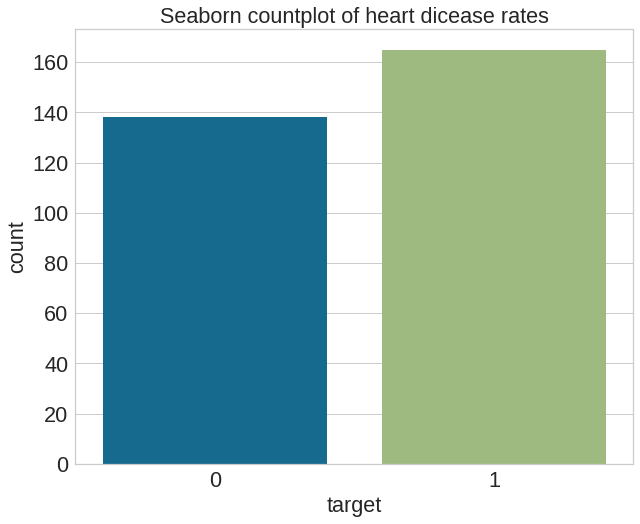

In [ ]:
ax = sns.countplot(data=df, x='target')
ax.set_title("Seaborn countplot of heart dicease rates");

In [ ]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

# Create X, y and a train/test split



In [ ]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
173,58,1,2,132,224,0,0,173,0,3.2,2,2,3
261,52,1,0,112,230,0,1,160,0,0.0,2,1,2
37,54,1,2,150,232,0,0,165,0,1.6,2,0,3
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3
166,67,1,0,120,229,0,0,129,1,2.6,1,2,3


# Try DummyClassifier

In [ ]:
clf_dummy = DummyClassifier(strategy="most_frequent")
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.5789473684210527

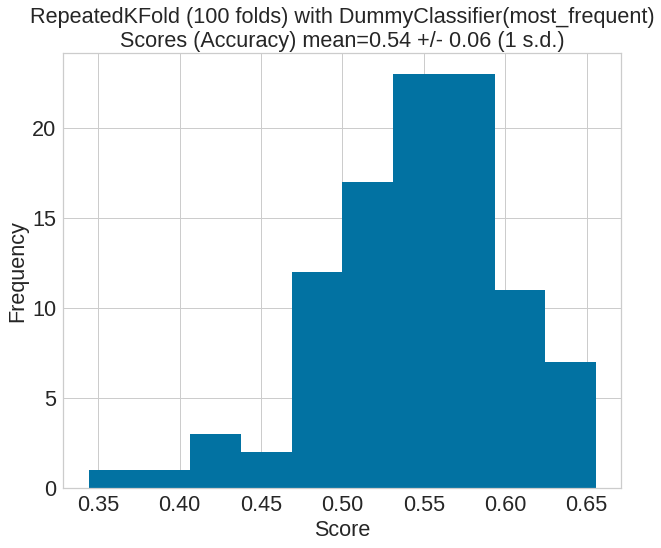

In [ ]:
strategy = "most_frequent"
clf_dummy = DummyClassifier(strategy=strategy)
scores = cross_val_score(clf_dummy, 
                         X, y, 
                         cv=RepeatedKFold(n_repeats=CV_N_REPEATS), 
                         scoring=None) 
scores_dummy = scores

score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

# Make a classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)  # hyperparameters optimised using BayesSearchCV
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### BayesSearchCV

* https://scikit-optimize.github.io/#skopt.BayesSearchCV
* should we use an AUC scorer (not accuracy?)

Note that the following error will be fixed: https://github.com/scikit-learn/scikit-learn/pull/9816
```
label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
```

In [ ]:
if True:
    # Set to True if we want to run the BayesSearchCV process
    params = {'n_estimators': (5,400),
              'max_depth': (3, 50)}

    optimiser = BayesSearchCV(clf, params, n_jobs=-1, n_iter=50)
    #opt = BayesSearchCV( SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )
    #executes bayesian optimization

    # note we're fitting on all the data, so we're optimising wrt to the test data (might be silly)
    optimiser.fit(X_train, y_train)

    print(optimiser.score(X_test, y_test), optimiser.best_params_)
    #pd.DataFrame(optimiser.cv_results_)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

0.868421052631579 OrderedDict([('max_depth', 3), ('n_estimators', 58)])


## Use a good configuration

In [ ]:
clf.score(X_test, y_test)

0.8157894736842105

### Check variance in prediction quality

In [ ]:
scores = cross_val_score(clf, X, y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS), n_jobs=-1)
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

Scores mean=0.82 +/- 0.05 (1 s.d.)


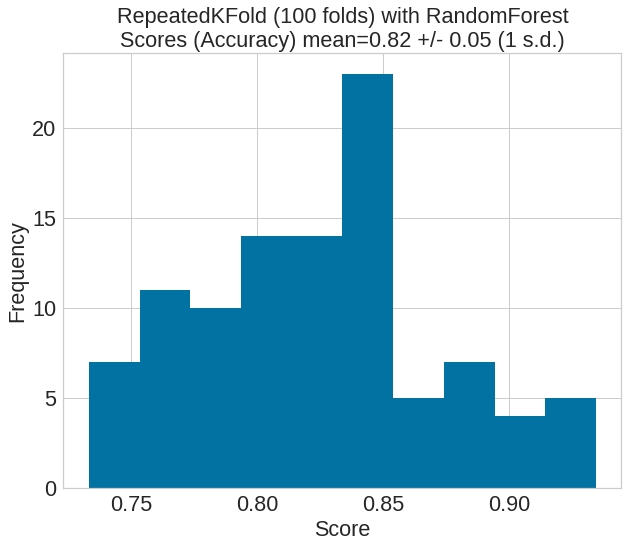

In [ ]:
score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

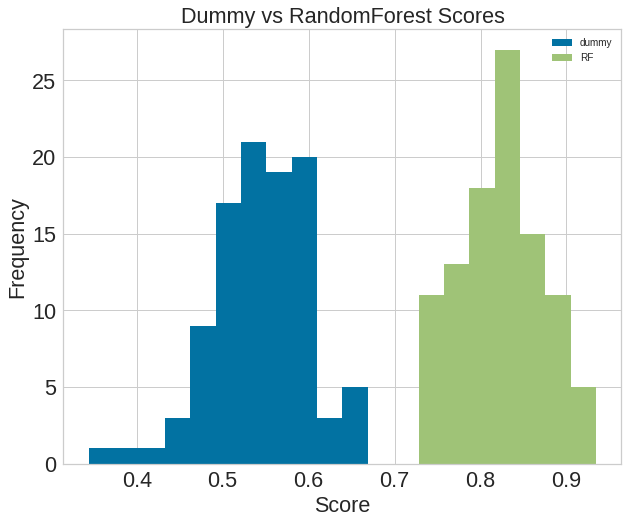

In [ ]:
fig, ax = plt.subplots()
df_dummy_est_scores = pd.DataFrame({'dummy': scores_dummy, 'RF': scores_est})
df_dummy_est_scores.plot(kind='hist', ax=ax, bins=20)
ax.set_xlabel("Score")
ax.set_title("Dummy vs RandomForest Scores");

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8421052631578947

# Feature weights vs Permutation Importance

In [ ]:
# https://github.com/TeamHG-Memex/eli5/issues/252
clf_to_explain = clf
try:
    clf.__getattribute__("get_booster")
    clf_to_explain = clf.get_booster()
except AttributeError:
    pass

In [ ]:
feature_names = X.columns.values 
explain_weights(clf, feature_names=feature_names)

Weight,Feature
0.1226 ± 0.1352,thalach
0.1225 ± 0.1857,cp
0.1154 ± 0.1498,ca
0.1150 ± 0.2003,thal
0.1051 ± 0.1423,oldpeak
0.0862 ± 0.0995,age
0.0784 ± 0.0845,chol
0.0720 ± 0.0739,trestbps
0.0679 ± 0.1597,exang
0.0507 ± 0.0822,sex


* https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance

In [ ]:
# workaround for bug https://github.com/TeamHG-Memex/eli5/issues/256
X_train_dbg = X_train.to_numpy()
y_train_dbg = y_train.to_numpy()
X_test_dbg = X_test.to_numpy()
y_test_dbg = y_test.to_numpy()
clf.fit(X_train_dbg, y_train_dbg) 
#perm = PermutationImportance(clf).fit(X_test_dbg, y_test_dbg)
perm = PermutationImportance(clf).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.0658 ± 0.0372,ca
0.0553 ± 0.0510,thal
0.0526 ± 0.0372,cp
0.0105 ± 0.0453,oldpeak
0.0079 ± 0.0211,sex
0.0079 ± 0.0129,slope
0.0026 ± 0.0105,fbs
0 ± 0.0000,restecg
-0.0000 ± 0.0166,chol
-0.0026 ± 0.0197,exang


### Add a confusion matrix

Note that red means "not 100%" and yellow indicates off-axis non-zero results. Docs: http://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

Tiny font issue: https://github.com/DistrictDataLabs/yellowbrick/issues/301

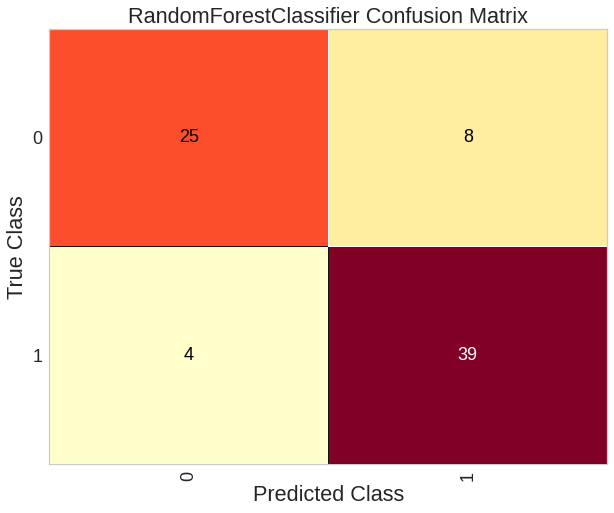

In [ ]:
fig, ax = plt.subplots()
cm = ConfusionMatrix(clf, classes=[0, 1], ax=ax)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, y_test)

#How did we do?
cm.poof()

## Make histograms from the confusion matrix

In [ ]:
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)

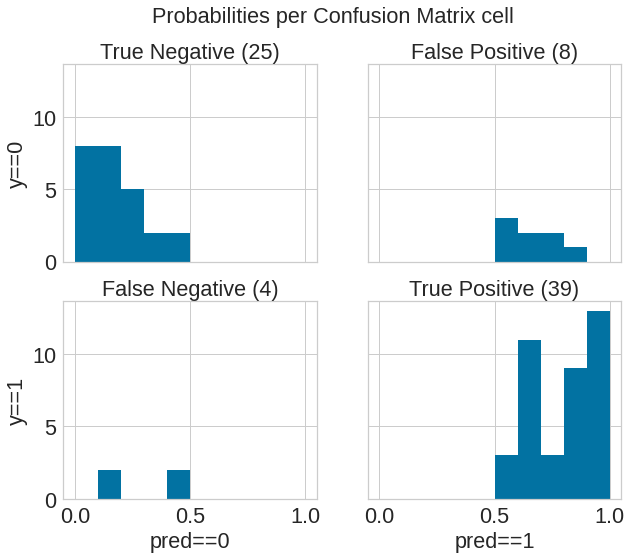

In [ ]:
df_predictions = pd.DataFrame({'y': y_test, 'y_proba': y_pred_proba[:,1]})
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
# show true-pos 

bins = np.arange(0, 1.01, 0.1)

def show_quarter(df, query, col, title, ax, bins, x_label=None, y_label=None):
    results = df.query(query)
    results[col].hist(ax=ax, bins=bins); 
    if y_label:
        ax.set_ylabel(y_label)
    if x_label:
        ax.set_xlabel(x_label)
    ax.set_title(title + " ({})".format(results.shape[0])) #IANBOB
show_quarter(df_predictions, "y==0 and y_proba < 0.5", "y_proba", "True Negative", axs[0][0], bins, y_label="y==0")
show_quarter(df_predictions, "y==0 and y_proba >= 0.5", "y_proba", "False Positive", axs[0][1], bins)
show_quarter(df_predictions, "y==1 and y_proba >= 0.5", "y_proba", "True Positive", axs[1][1], bins, x_label="pred==1")
show_quarter(df_predictions, "y==1 and y_proba < 0.5", "y_proba", "False Negative", axs[1][0], bins, x_label="pred==0", y_label="y==1")
fig.suptitle("Probabilities per Confusion Matrix cell");

## Classification report

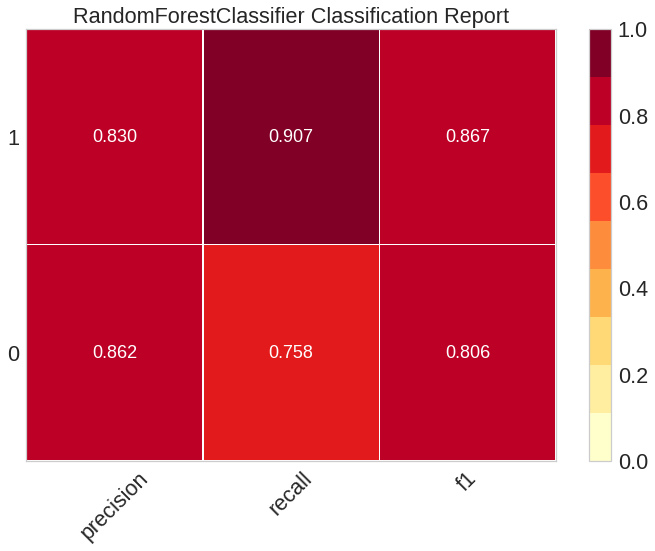

In [ ]:
fig, ax = plt.subplots()
visualizer = ClassificationReport(clf, classes=[0, 1], ax=ax)
ax.grid(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

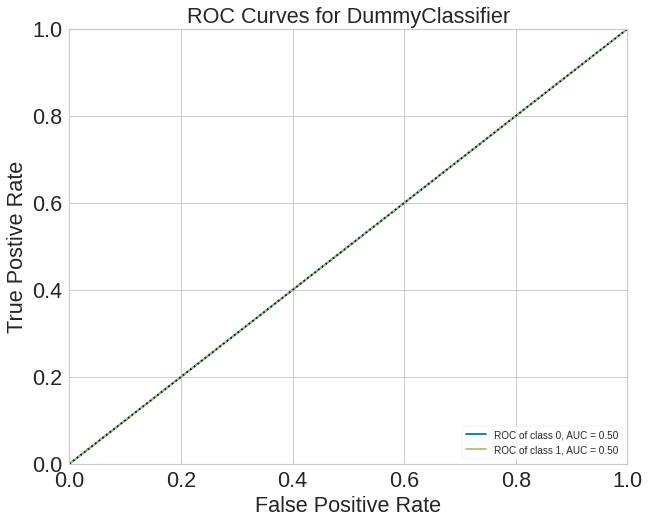

In [ ]:
visualizer = ROCAUC(clf_dummy, micro=False, macro=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

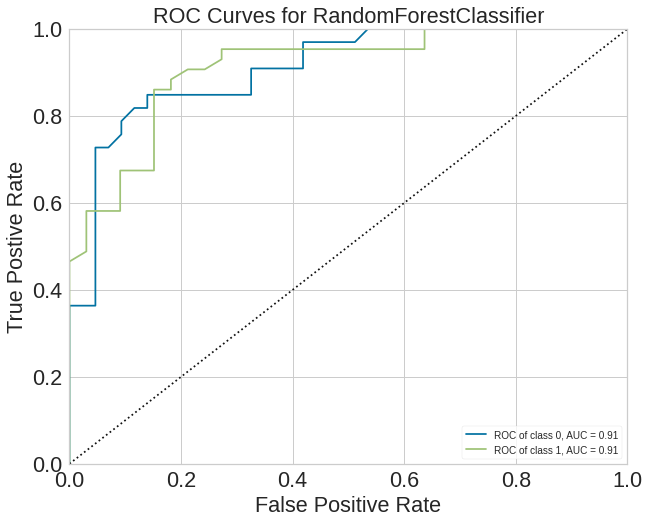

In [ ]:
visualizer = ROCAUC(clf, micro=False, macro=False, per_class=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### Create an untuned Logistsicregression classifier for a comparison

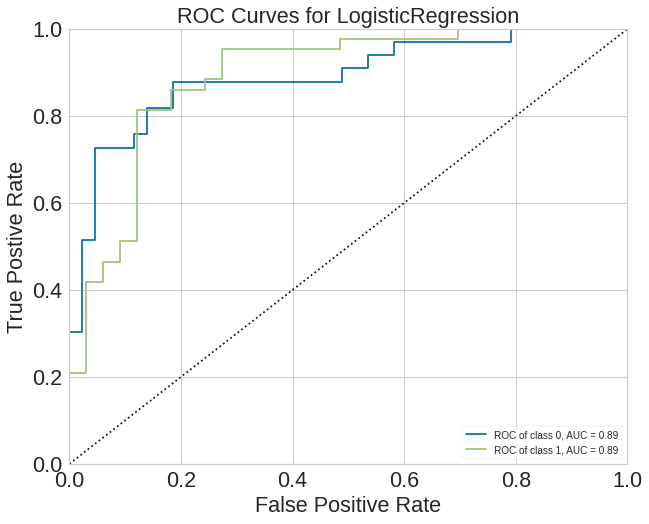

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=1000)
visualizer = ROCAUC(clf_lr, micro=False, macro=False, per_class=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# Identify worsts predictions

In [ ]:
proba_y_test_clf = clf.predict_proba(X_test)[:,1]
df_test = pd.DataFrame({'proba': proba_y_test_clf}, index=X_test.index)
df_test['truth'] = y_test.values
df_test['abs_error'] = (df_test.truth - df_test.proba).abs()
df_test.head(5)

,proba,truth,abs_error
225,0.170,0,0.170
152,0.555,1,0.445
228,0.660,0,0.660
201,0.000,0,0.000
52,0.150,1,0.850


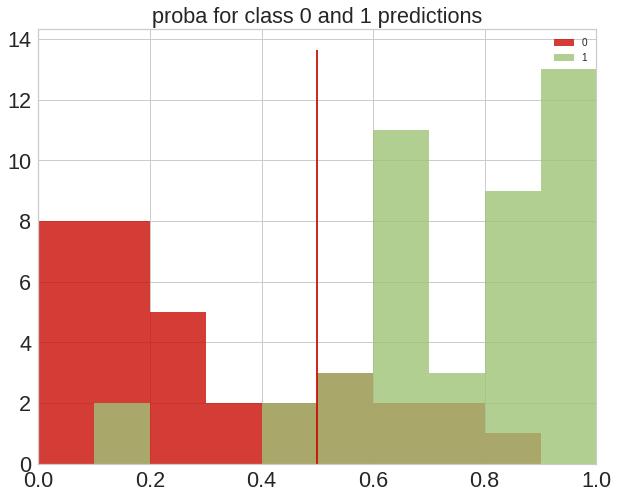

In [ ]:
fig, ax = plt.subplots()
bins = np.arange(0, 1.01, 0.1)
df_test.query("truth==0")['proba'].hist(ax=ax, color='r', alpha=0.8, bins=bins, label="0")
df_test.query("truth==1")['proba'].hist(ax=ax, color='g', alpha=0.8, bins=bins, label="1");
ax.legend()
ax.vlines(0.5, 0, ax.get_ylim()[1], color='r')
ax.set_xlim((0, 1.0));
ax.set_title("proba for class 0 and 1 predictions");

In [ ]:
# Get worst errors for this class
df_test_worst_errors_by_class = df_test.query('truth==1'). \
                                sort_values(by='abs_error', 
                                ascending=False)
df_test_worst_errors_by_class.head(10)

,proba,truth,abs_error
52,0.150,1,0.850
97,0.165,1,0.835
34,0.455,1,0.545
20,0.490,1,0.510
59,0.545,1,0.455
152,0.555,1,0.445
111,0.595,1,0.405
27,0.605,1,0.395
103,0.625,1,0.375
126,0.635,1,0.365


In [ ]:
index_to_debug = df_test_worst_errors_by_class.index[0]
print("Debugging", index_to_debug)
X_test.loc[index_to_debug]

Debugging 52


age          62.0
sex           1.0
cp            2.0
trestbps    130.0
chol        231.0
fbs           0.0
restecg       1.0
thalach     146.0
exang         0.0
oldpeak       1.8
slope         1.0
ca            3.0
thal          3.0
Name: 52, dtype: float64

In [ ]:
# use iloc to index by integer into X_test
clf.predict_proba([X_test.loc[index_to_debug]]), y_test.loc[index_to_debug]

(array([[0.85, 0.15]]), 1)

In [ ]:
test_features_prediction = pd.concat((X_test, df_test), axis=1)
print(test_features_prediction.loc[index_to_debug])


age           62.00
sex            1.00
cp             2.00
trestbps     130.00
chol         231.00
fbs            0.00
restecg        1.00
thalach      146.00
exang          0.00
oldpeak        1.80
slope          1.00
ca             3.00
thal           3.00
proba          0.15
truth          1.00
abs_error      0.85
Name: 52, dtype: float64


In [ ]:
# given the filter above (for 1 or 0 errors), show the worst offenders
test_features_prediction.loc[df_test_worst_errors_by_class.index].head(10) \
.style \
.background_gradient(cmap='summer', low=2) \
.set_caption('For worsts errors, show the features we use')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,proba,truth,abs_error
52,62,1,2,130,231,0,1,146,0,1.800000,1,3,3,0.150000,1,0.850000
97,52,1,0,108,233,1,1,147,0,0.100000,2,3,3,0.165000,1,0.835000
34,51,1,3,125,213,0,0,125,1,1.400000,2,1,2,0.455000,1,0.545000
20,59,1,0,135,234,0,1,161,0,0.500000,1,0,3,0.490000,1,0.510000
59,57,0,0,128,303,0,0,159,0,0.000000,2,1,2,0.545000,1,0.455000
152,64,1,3,170,227,0,0,155,0,0.600000,1,0,3,0.555000,1,0.445000
111,57,1,2,150,126,1,1,173,0,0.200000,2,1,3,0.595000,1,0.405000
27,51,1,2,110,175,0,1,123,0,0.600000,2,0,2,0.605000,1,0.395000
103,42,1,2,120,240,1,1,194,0,0.800000,0,0,3,0.625000,1,0.375000
126,47,1,0,112,204,0,1,143,0,0.100000,2,0,2,0.635000,1,0.365000


In [ ]:
test_features_prediction.query("sex==1 and abs_error > 0.7") \
.style \
.background_gradient(cmap='summer', low=2) \
.set_caption('Focus on males with worst errors')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,proba,truth,abs_error
52,62,1,2,130,231,0,1,146,0,1.800000,1,3,3,0.150000,1,0.850000
97,52,1,0,108,233,1,1,147,0,0.100000,2,3,3,0.165000,1,0.835000
287,57,1,1,154,232,0,0,164,0,0.000000,2,1,2,0.715000,0,0.715000


### Comparing males and females

In [ ]:
subset_features_predictions = test_features_prediction.query('sex==1') 
print("Number of examples:", subset_features_predictions.shape[0])
print(classification_report(subset_features_predictions.truth, 
                            subset_features_predictions.proba>0.5))

Number of examples: 55
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.84      0.87      0.85        30

    accuracy                           0.84        55
   macro avg       0.84      0.83      0.83        55
weighted avg       0.84      0.84      0.84        55



In [ ]:
subset_features_predictions = test_features_prediction.query('sex==0') 
print("Number of examples:", subset_features_predictions.shape[0])
print(classification_report(subset_features_predictions.truth, 
                            subset_features_predictions.proba>0.5))

Number of examples: 21
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.81      1.00      0.90        13

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21



# ELI5 explain accurate results

* http://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html

In [ ]:
best_predictions = test_features_prediction.sort_values('abs_error', ascending=True)
best_predictions.head(20) \
.style \
.background_gradient(cmap='viridis', low=0.7)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,proba,truth,abs_error
201,60,1,0,125,258,0,0,141,1,2.800000,1,1,3,0.000000,0,0.000000
157,35,1,1,122,192,0,1,174,0,0.000000,2,0,2,0.990000,1,0.010000
74,43,0,2,122,213,0,1,165,0,0.200000,1,0,2,0.990000,1,0.010000
124,39,0,2,94,199,0,1,179,0,0.000000,2,0,2,0.980000,1,0.020000
46,44,1,2,140,235,0,0,180,0,0.000000,2,0,2,0.975000,1,0.025000
134,41,0,1,126,306,0,1,163,0,0.000000,2,0,2,0.975000,1,0.025000
81,45,1,1,128,308,0,0,170,0,0.000000,2,0,2,0.970000,1,0.030000
12,49,1,1,130,266,0,1,171,0,0.600000,2,0,2,0.970000,1,0.030000
135,49,0,0,130,269,0,1,163,0,0.000000,2,0,2,0.965000,1,0.035000
232,55,1,0,160,289,0,0,145,1,0.800000,1,1,3,0.040000,0,0.040000


In [ ]:
# https://github.com/TeamHG-Memex/eli5/issues/223
# http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
patient_id_to_explain = best_predictions.index[8] 
example = X_test.loc[patient_id_to_explain] 
answer = y_test.loc[patient_id_to_explain]
print("Truth (passenger id {}): {}".format(patient_id_to_explain, answer))

eli5.show_prediction(clf, 
                     example, 
                     target_names=['healthy', 'sick'], 
                     show_feature_values=True)

Truth (passenger id 135): 1


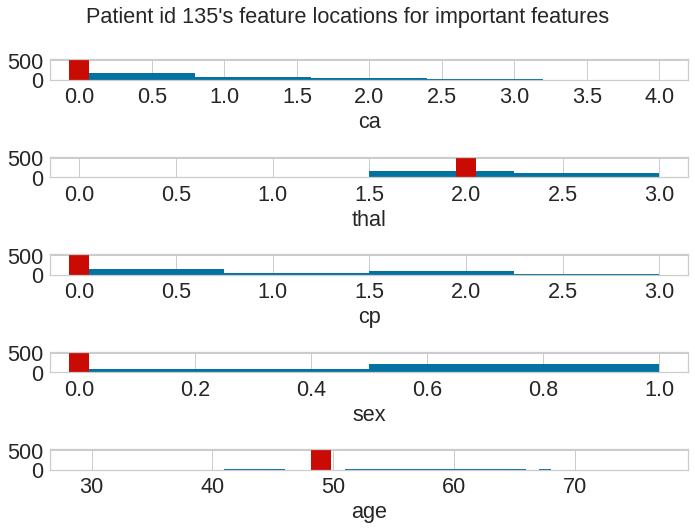

In [ ]:
fig, axs = plt.subplots(nrows=5)
bins = {'ca': 5, 'thal': 4, 'cp': 4, 'sex': 2, 'age': range(29, 78)}
for row_nbr, feature in enumerate(['ca', 'thal', 'cp', 'sex', 'age']):
    ax = axs[row_nbr]
    df[feature].hist(ax=ax, bins=bins[feature])
    ax.set_xlabel(feature)
    x = example[feature]
    ax.vlines(x, 0, 500, color='r', linewidth=20)
fig.suptitle("Patient id {}'s feature locations for important features".format(patient_id_to_explain))
fig.tight_layout(rect=[0.0, 0.05, 1, 0.93])

### LIME

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=["healthy", "sick"], discretize_continuous=True)


In [ ]:
exp = explainer.explain_instance(example, clf.predict_proba, num_features=7, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
exp.as_map()

{1: [(11, 0.2116492945340258),
  (12, 0.18030297820081756),
  (2, -0.1516314832803041),
  (1, 0.12100068190918979),
  (8, 0.0926211490205066),
  (9, 0.080399671477029),
  (10, 0.05353756606382516)]}

# Learning Curves

* Training score gets worse as data size incrases - it isn't overfitting (it isn't suffering from high bias)
* Test score improves and plateaus - but it is still improving
* High variance (large gap between train & test) - probably we want more data or better features
* Maybe the estimator isn't well-tuned enough? Data set's size could be improved
* http://www.ritchieng.com/machinelearning-learning-curve/

In [ ]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


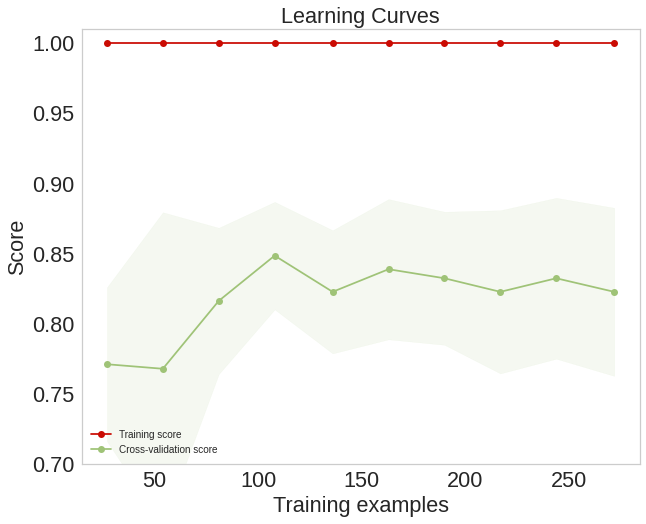

In [ ]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
train_sizes = np.linspace(.1, 1.0, 10)
plot_learning_curve(clf, title, X, y, (0.7, 1.01), cv=cv, n_jobs=-1, train_sizes=train_sizes);

# SHAP

"Great! The general idea is to get the total of all the positive SHAP values, and then all the negative SHAP values. You then draw a red and blue bar of each of those lengths ending at the predicted value (with an arrow notch at the start). Then you sort the positive SHAP values by magnitude and draw an inwards facing light red arrow at each junction between the positive SHAP values (note they may overlap at the outside when you get to small SHAP values). Then repeat this for the negative SHAP values. Finally the hard part is determining how many feature labels will fit and then drawing all the polygons and labels and borders in the right places."
https://github.com/slundberg/shap/issues/27

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456460 sha256=33339bef1744df831c479c34ec97ec1bfbefa397703d7eae2f3adda2fe5b1884
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
if True:
    # https://github.com/slundberg/shap/blob/master/notebooks/Iris%20classification%20with%20scikit-learn.ipynb
    import shap
    # it is slow to train
    
    # NOTE USING _dbg (.ax_matrix) variants to see if this helps - NO, doesn't help (no .iloc)

    # use Kernel SHAP to explain test set predictions
    print("X_train", X_train.shape)
    explainer = shap.KernelExplainer(clf.predict_proba, X_train)#, link="logit")
    shap_values = explainer.shap_values(X_test)#, nsamples=20) # IAN TRY
    
    #shap_values = np.array(shap_values) # IAN TRY
    
    #shap.force_plot(shap_values[0][0,:], X_test.iloc[0,:])#, link="logit")
    # shap.visualize(shap_values[0], X_test) # same as force_plot
    
    # shap.force_plot(shap_values[0][0], X_test.iloc[0]) # single item, nothing seen?

Using 227 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


X_train (227, 13)


In [ ]:
# load JS visualization code to notebook
shap.initjs() 
shap.force_plot(explainer.expected_value[1], shap_values[1])

In [ ]:
y_test.head()

225    0
152    1
228    0
201    0
52     1
Name: target, dtype: int64

In [ ]:
patient_id_to_explain = 152
# use eli5 index to check into our X_test array
idx_to_debug = (X_test.index == patient_id_to_explain).argmax()
print("Patient id", patient_id_to_explain, "Truth:", y_test.iloc[idx_to_debug])
print(clf.predict_proba([X_test.iloc[idx_to_debug]]))
X_test.iloc[idx_to_debug]

Patient id 152 Truth: 1
[[0.445 0.555]]


age          64.0
sex           1.0
cp            3.0
trestbps    170.0
chol        227.0
fbs           0.0
restecg       0.0
thalach     155.0
exang         0.0
oldpeak       0.6
slope         1.0
ca            0.0
thal          3.0
Name: 152, dtype: float64

In [ ]:
# load JS visualization code to notebook
shap.initjs() 
shap.force_plot(explainer.expected_value[1], shap_values[1][idx_to_debug]) 

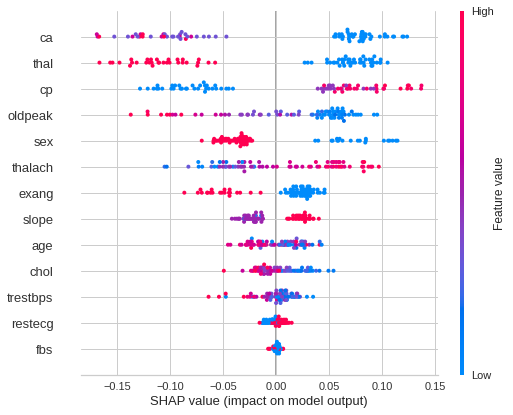

In [ ]:
# https://github.com/slundberg/shap/blob/master/notebooks/Census%20income%20classification%20with%20scikit-learn.ipynb
shap.summary_plot(shap_values[1], X_test)

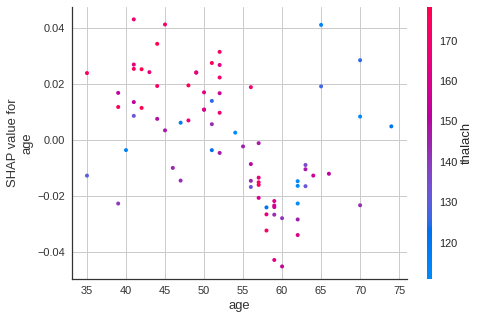

In [ ]:
shap.dependence_plot("age", shap_values[1], X_test)

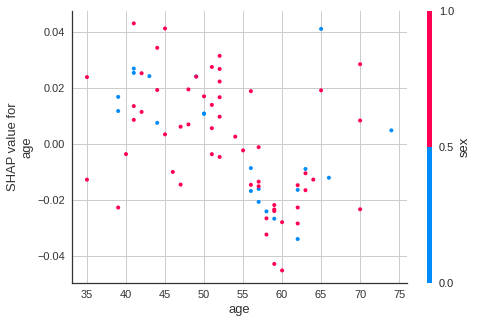

In [ ]:
shap.dependence_plot("age", shap_values[1], X_test, interaction_index="sex")

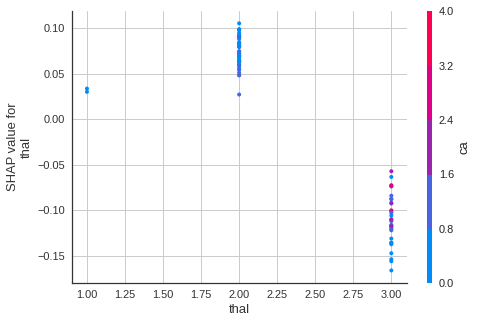

In [ ]:
shap.dependence_plot("thal", shap_values[1], X_test, interaction_index="ca")

# TSNE

Use T-SNE to group similar examples (by features, not by target) onto a 2D plane. Set their symbol to be survived/died. Set their colour to be "size of error". Do a visual diagnostic for whether the errors seem to be grouped around areas of similar features.

In [ ]:
# Note even with random_state we cannot get repeatable results
# The structure is similar, groupings are similar, placement changes
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=100, random_state=0)
X_test_embedded = TSNE(n_components=2).fit_transform(X_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


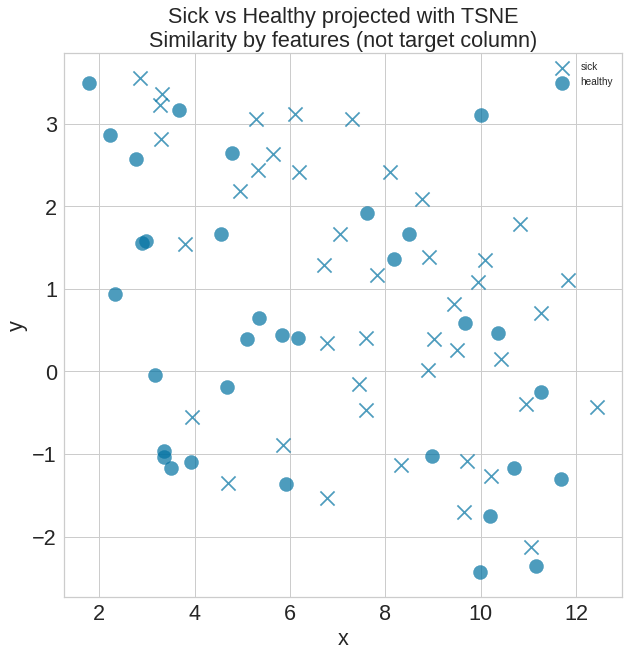

In [ ]:
df_X_test_embedded = pd.DataFrame(X_test_embedded, columns=['x', 'y'])
df_X_test_embedded['target'] = y_test.values
df_X_test_embedded['abs_error'] = test_features_prediction.abs_error.values
df_X_test_embedded['test_features_prediction_index'] = test_features_prediction.index

# colour by abs_error or target
#df_X_test_embedded.plot(kind="scatter", x="x", y="y", c='target', cmap='hot');

fig, ax = plt.subplots(figsize=(10, 10))
alpha = 0.7
MARKER_MULTIPLIER = 200
df_X_test_embedded_scatter = df_X_test_embedded.query("target==True")
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                marker="x", s=MARKER_MULTIPLIER,
                                ax=ax, alpha=alpha, label="sick");
df_X_test_embedded_scatter = df_X_test_embedded.query("target==False")
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                 marker="o", s=MARKER_MULTIPLIER,
                                label="healthy", alpha=alpha, ax=ax,);

ax.legend()
ax.set_title("Sick vs Healthy projected with TSNE\nSimilarity by features (not target column)");

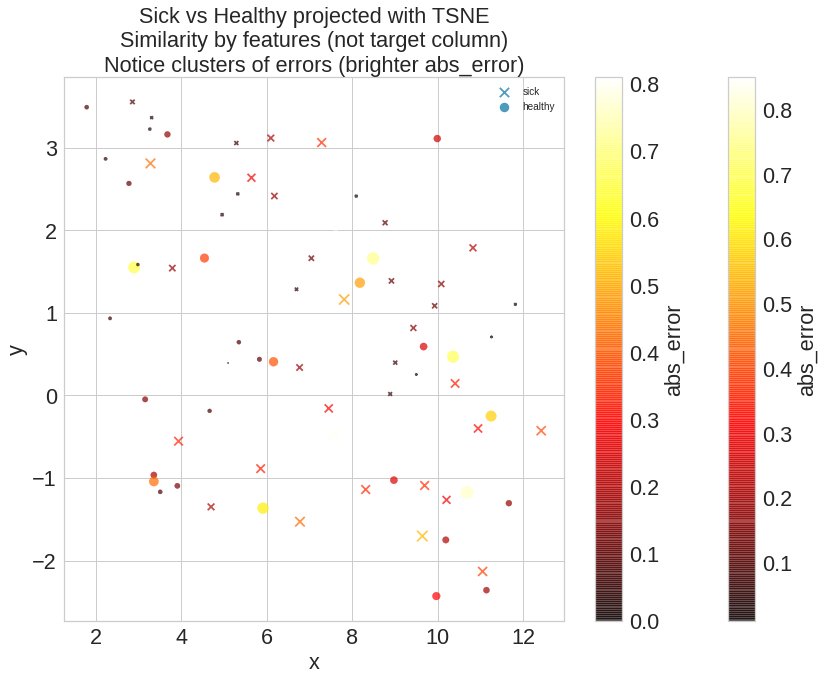

In [ ]:
# note we could 'zoom in'
#subset_of_imputed_ages_query = "-x > 5 and -y > 10"
#df_X_test_embedded_subset = df_X_test_embedded.query(subset_of_imputed_ages_query)

# colour by abs_error or target
markers = np.where(df_X_test_embedded.target, "o", "x")

fig, ax = plt.subplots(figsize=(14, 10))
alpha = 0.7
MARKER_MULTIPLIER = 200
df_X_test_embedded_scatter = df_X_test_embedded.query("target==True")
marker_size = (df_X_test_embedded_scatter.abs_error + 0.01) * MARKER_MULTIPLIER
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                c='abs_error', marker="x", s=marker_size,
                                                cmap='hot', ax=ax, alpha=alpha, label="sick");
df_X_test_embedded_scatter = df_X_test_embedded.query("target==False")
marker_size = (df_X_test_embedded_scatter.abs_error + 0.01) * MARKER_MULTIPLIER
df_X_test_embedded_scatter.plot(kind="scatter", x="x", y="y", 
                                                 c='abs_error', marker="o", s=marker_size,
                                                 cmap='hot', ax=ax, alpha=alpha, label="healthy");
ax.legend()
ax.set_title("Sick vs Healthy projected with TSNE\nSimilarity by features (not target column)\nNotice clusters of errors (brighter abs_error)");

In [ ]:
df.loc[265]

age          66.0
sex           1.0
cp            0.0
trestbps    112.0
chol        212.0
fbs           0.0
restecg       0.0
thalach     132.0
exang         1.0
oldpeak       0.1
slope         2.0
ca            1.0
thal          2.0
target        0.0
Name: 265, dtype: float64

### Reviewing ages against truth

* https://www.encyclopedia-titanica.org/titanic-passenger-list/

* Willey, Mr. Edward (passenger 649), imputed 28, actual 21, correct (died)
* Moussa, Mrs. (Mantoura Boulos) (368), imputed 28, actual 35, correct (survived)
* Henry, Miss. Delia (265), imputed 28, actual 22, error (predicted survived, she died)

In [ ]:
# note that this query depends on the non-deterministic TSNE run
# see the presentations (linked at the top of this Notebook) for a clear example
query = "x > 0 and y > 0"
#query = "x < -4 and y < 1"
#query = "-x > 4 and y < 1" # odd group of similar age_imputed

pd.concat((X_test.loc[df_X_test_embedded.query(query).test_features_prediction_index], \
    df_X_test_embedded.query(query).set_index('test_features_prediction_index')), axis=1) \
.style \
.background_gradient(cmap='viridis', low=0.7)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,x,y,target,abs_error
228,59,1,3,170,288,0,0,159,0,0.200000,1,0,3,2.901702,1.551798,0,0.660000
201,60,1,0,125,258,0,0,141,1,2.800000,1,1,3,5.101312,0.393483,0,0.000000
52,62,1,2,130,231,0,1,146,0,1.800000,1,3,3,7.589400,0.405456,1,0.850000
245,48,1,0,124,274,0,0,166,0,0.500000,1,0,3,4.785730,2.642126,0,0.515000
168,63,1,0,130,254,0,0,147,0,1.400000,1,1,3,5.353016,0.645444,0,0.075000
223,56,0,0,200,288,1,0,133,1,4.000000,0,2,3,2.340042,0.934054,0,0.050000
217,63,1,0,130,330,1,0,132,1,1.800000,2,3,3,2.235089,2.866625,0,0.050000
135,49,0,0,130,269,0,1,163,0,0.000000,2,0,2,4.960842,2.189346,1,0.035000
12,49,1,1,130,266,0,1,171,0,0.600000,2,0,2,5.328277,2.441849,1,0.030000
15,50,0,2,120,219,0,1,158,0,1.600000,1,0,2,8.892756,0.017884,1,0.060000


In [ ]:
# note that this query all depends on the non-deterministic run from TSNE (which is a pain) 
# see the presentations (linked at the top of this Notebook) for a clear example
query = "x > 2 and x < 6 and y > 2 and y < 5"

pd.concat((X_test.loc[df_X_test_embedded.query(query).test_features_prediction_index], \
    df_X_test_embedded.query(query).set_index('test_features_prediction_index')), axis=1) \
.style \
.background_gradient(cmap='viridis', low=0.7)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,x,y,target,abs_error
245,48,1,0,124,274,0,0,166,0,0.500000,1,0,3,4.785730,2.642126,0,0.515000
217,63,1,0,130,330,1,0,132,1,1.800000,2,3,3,2.235089,2.866625,0,0.050000
135,49,0,0,130,269,0,1,163,0,0.000000,2,0,2,4.960842,2.189346,1,0.035000
12,49,1,1,130,266,0,1,171,0,0.600000,2,0,2,5.328277,2.441849,1,0.030000
255,45,1,0,142,309,0,0,147,1,0.000000,1,3,3,2.781845,2.568584,0,0.110000
134,41,0,1,126,306,0,1,163,0,0.000000,2,0,2,3.270642,3.227098,1,0.025000
81,45,1,1,128,308,0,0,170,0,0.000000,2,0,2,3.313902,3.365130,1,0.030000
59,57,0,0,128,303,0,0,159,0,0.000000,2,1,2,3.285171,2.811164,1,0.455000
7,44,1,1,120,263,0,1,173,0,0.000000,2,0,3,5.647685,2.637646,1,0.300000
45,52,1,1,120,325,0,1,172,0,0.200000,2,0,2,2.863579,3.556202,1,0.090000


# End of Notebook

In [ ]:
print("Finished:", datetime.datetime.now())

Finished: 2020-10-05 00:29:59.674776
